<a href="https://colab.research.google.com/github/Umaymach/PFE_seasons_clustering/blob/main/Functions_Clustering_agri_seasons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [116]:
%pip install tslearn
%pip install netdata_pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [117]:

import pandas as pd
import requests
import csv
import numpy as np
import datetime as dt
import matplotlib as plt
from yellowbrick.cluster.elbow import kelbow_visualizer
from tslearn.clustering import TimeSeriesKMeans, KShape, KernelKMeans
import pandas as pd
import numpy as np
import tslearn.clustering
from tslearn.clustering import TimeSeriesKMeans, KShape, KernelKMeans
from sklearn.preprocessing import StandardScaler
from tslearn.metrics import dtw

from tslearn.preprocessing import TimeSeriesScalerMeanVariance


##**collecting data**

In [118]:
#Collect of the data using API

def datacollection(longitude, latitude):
    output = r""
    url = r"https://power.larc.nasa.gov/api/temporal/daily/point?start=1981&end=2021&longitude={longitude}&latitude={latitude}&community=ag&parameters=T2M_MAX,T2M_MIN,PRECTOTCORR,QV2M,WS10M&format=csv&header=False"
    request = url.format(longitude=longitude, latitude=latitude)
    response = requests.get(url=request, verify=True, timeout=30.00)
    open(f'Data_{latitude,longitude}.csv', 'wb').write(response.content)
    data= pd.read_csv(f'Data_{latitude,longitude}.csv')
    return data
    

In [119]:
a=datacollection(33.5731, -7.5898)
a

,YEAR,DOY,T2M_MAX,...,PRECTOTCORR,QV2M,WS10M
0,1981,1,23.98,...,5.55,13.55,4.43
1,1981,2,27.24,...,0.12,12.39,3.74
2,1981,3,28.63,...,0.01,11.35,4.32
3,1981,4,28.80,...,0.21,11.84,4.48
4,1981,5,28.98,...,0.33,12.76,3.62
...,...,...,...,...,...,...,...
14970,2021,361,27.81,...,1.42,13.31,5.03
14971,2021,362,28.00,...,3.86,13.00,4.30
14972,2021,363,28.76,...,13.23,11.84,4.11
14973,2021,364,28.51,...,6.29,13.37,3.35


In [120]:
#preparing the form of the data
import numpy as np
def formatpreparing(data):
    data=data.rename(columns={'YEAR': 'Année'})
    data["combined"] = data["Année"]*1000 + data["DOY"]
    data["Date"] = pd.to_datetime(data["combined"], format = "%Y%j")
    data['Jour-Mois']=data['Date'].dt.strftime('%d-%m')
    data=data.set_index("Date")
    data=data[['Année',"T2M_MAX",'T2M_MIN','PRECTOTCORR','QV2M','WS10M','Jour-Mois']]
    return data


In [121]:
b=formatpreparing(a)
b

,Année,T2M_MAX,T2M_MIN,...,QV2M,WS10M,Jour-Mois
Date,,,,,,,
1981-01-01,1981,23.98,17.05,...,13.55,4.43,01-01
1981-01-02,1981,27.24,15.84,...,12.39,3.74,02-01
1981-01-03,1981,28.63,14.39,...,11.35,4.32,03-01
1981-01-04,1981,28.80,14.83,...,11.84,4.48,04-01
1981-01-05,1981,28.98,17.15,...,12.76,3.62,05-01
...,...,...,...,...,...,...,...
2021-12-27,2021,27.81,16.58,...,13.31,5.03,27-12
2021-12-28,2021,28.00,16.62,...,13.00,4.30,28-12
2021-12-29,2021,28.76,15.19,...,11.84,4.11,29-12


In [122]:
#Affichage des données 
def prepare_data(data, season_debute_month,season_debute_day, season_end_month,season_end_day):
    #take only the agricultural season
    data=data[(data.index.month >= season_debute_month) | (data.index.month <= season_end_month)]
    data=data[data.index >=dt(1981,season_debute_month,season_debute_day)]
    #create the column saison agricole
    years = data["Année"].unique()
    data["Saison agricole"] = [0 for i in range(data.shape[0])]
    for year in years:
        data.loc[(data.index >= dt(year, season_debute_month, season_debute_day)) & (data.index <= dt(year+1, season_end_month, season_end_day)), "Saison agricole"] = f"{year}-{year+1}"
    data=data[["T2M_MAX",'T2M_MIN','PRECTOTCORR','QV2M','WS10M','Saison agricole']]
    data=data.reset_index()
    #create column jour mois
    data['Jour-Mois']=data["Date"].dt.strftime('%d-%m')
    return data


In [123]:
from datetime import datetime as dt
c=prepare_data(b,10,1,6,30)
c.head(n=93)

,Date,T2M_MAX,T2M_MIN,...,WS10M,Saison agricole,Jour-Mois
0,1981-10-01,30.37,16.43,...,6.05,1981-1982,01-10
1,1981-10-02,30.33,13.30,...,5.34,1981-1982,02-10
2,1981-10-03,31.40,14.93,...,4.48,1981-1982,03-10
3,1981-10-04,31.89,15.90,...,5.37,1981-1982,04-10
4,1981-10-05,32.80,16.45,...,5.55,1981-1982,05-10
...,...,...,...,...,...,...,...
88,1981-12-28,24.33,18.43,...,3.39,1981-1982,28-12
89,1981-12-29,27.57,17.29,...,4.22,1981-1982,29-12
90,1981-12-30,26.58,17.58,...,3.83,1981-1982,30-12
91,1981-12-31,25.87,18.05,...,3.91,1981-1982,31-12


In [124]:
#Transformation de la base de données AGDD et cumul de la precipitation
def calculat_AGDD_APRE(data, culture, Tbase):
    #data=pd.DataFrame(data)
    data[f'GDD de {culture}']=(data["T2M_MAX"]+data["T2M_MIN"])/2-Tbase
    data[f'GDD de {culture}'] = data[f'GDD de {culture}'].clip(lower = 0)
    data['AGDD'] = data.groupby(['Saison agricole'])[f'GDD de {culture}'].transform(pd.Series.cumsum)
    data['APRE'] = data.groupby(['Saison agricole'])['PRECTOTCORR'].transform(pd.Series.cumsum)
    data=data[["Date","AGDD",'APRE','QV2M','WS10M','Jour-Mois','Saison agricole']]
    data=data.set_index('Saison agricole')
    return data

In [125]:
d=calculat_AGDD_APRE(c, "Blé", 6)
d.head(n=276)

,Date,AGDD,APRE,QV2M,WS10M,Jour-Mois
Saison agricole,,,,,,
1981-1982,1981-10-01,17.400,0.00,8.85,6.05,01-10
1981-1982,1981-10-02,33.215,0.00,8.30,5.34,02-10
1981-1982,1981-10-03,50.380,0.00,8.67,4.48,03-10
1981-1982,1981-10-04,68.275,0.00,9.16,5.37,04-10
1981-1982,1981-10-05,86.900,0.00,8.91,5.55,05-10
...,...,...,...,...,...,...
1981-1982,1982-06-29,4177.815,918.73,8.42,6.04,29-06
1981-1982,1982-06-30,4191.715,918.73,9.16,6.09,30-06
1982-1983,1982-10-01,16.895,0.01,9.58,7.50,01-10


In [126]:
d.index.values

array(['1981-1982', '1981-1982', '1981-1982', ..., '2021-2022',
       '2021-2022', '2021-2022'], dtype=object)

In [127]:
#studying the clustering of AGDD
def pivot_with_AGDD(data):
    cols=data["Jour-Mois"].unique().tolist()
    data= data.pivot_table(index="Saison agricole", columns="Jour-Mois", values="AGDD")[cols[:-1]]
    data=data.drop('2021-2022')
    return data

In [128]:
#studying the clustering of APRE
def pivot_with_APRE(data):
    cols=data["Jour-Mois"].unique().tolist()
    data= data.pivot_table(index="Saison agricole", columns="Jour-Mois", values="APRE")[cols[:-1]]
    data=data.drop('2021-2022')
    return data

In [129]:
def pivot_with_QV2M(data):
    cols=data["Jour-Mois"].unique().tolist()
    data= data.pivot_table(index="Saison agricole", columns="Jour-Mois", values="QV2M")[cols[:-1]]
    data=data.drop('2021-2022')
    return data

In [130]:
def pivot_with_WS10M(data):
    cols=data["Jour-Mois"].unique().tolist()
    data= data.pivot_table(index="Saison agricole", columns="Jour-Mois", values="WS10M")[cols[:-1]]
    data=data.drop('2021-2022')
    return data

In [131]:
d["Jour-Mois"].values

array(['01-10', '02-10', '03-10', ..., '29-12', '30-12', '31-12'],
      dtype=object)

In [132]:
pd.set_option('max_columns',10)
T=pivot_with_AGDD(d)
T.head()

Jour-Mois,01-10,02-10,03-10,04-10,05-10,...,26-06,27-06,28-06,29-06,30-06
Saison agricole,,,,,,,,,,,
1981-1982,17.400,33.215,50.380,68.275,86.900,...,4140.545,4153.235,4165.300,4177.815,4191.715
1982-1983,16.895,33.555,50.300,67.570,85.815,...,4277.600,4291.020,4304.205,4317.275,4331.725
1983-1984,17.940,35.910,53.405,71.175,87.705,...,3919.955,3931.250,3942.825,3954.345,3965.400
1984-1985,15.885,31.590,48.710,65.155,82.470,...,3935.730,3947.165,3958.920,3970.480,3981.290
1985-1986,16.440,32.915,49.970,66.435,83.585,...,4056.235,4067.250,4078.180,4088.650,4100.105


In [133]:
T.isnull().sum().sum()

0

## **Drawing the plots**

In [134]:
def Plotting_seasons(data):
    TAGDD=pivot_with_AGDD(data)
    TAPRE= pivot_with_APRE(data)
    TQV2M=pivot_with_QV2M(data)
    TWS10M=pivot_with_WS10M(data)
    for var, i in [(TAGDD,"AGDD"),(TAPRE, "APRE"),(TQV2M,"QV2M"), (TWS10M,"WS10M")]:
        ax = var.T.plot(figsize=(20, 12))
        ax.set_ylabel(i, fontsize=20)
        ax.set_xlabel('Jour et mois', fontsize=20)
    return 

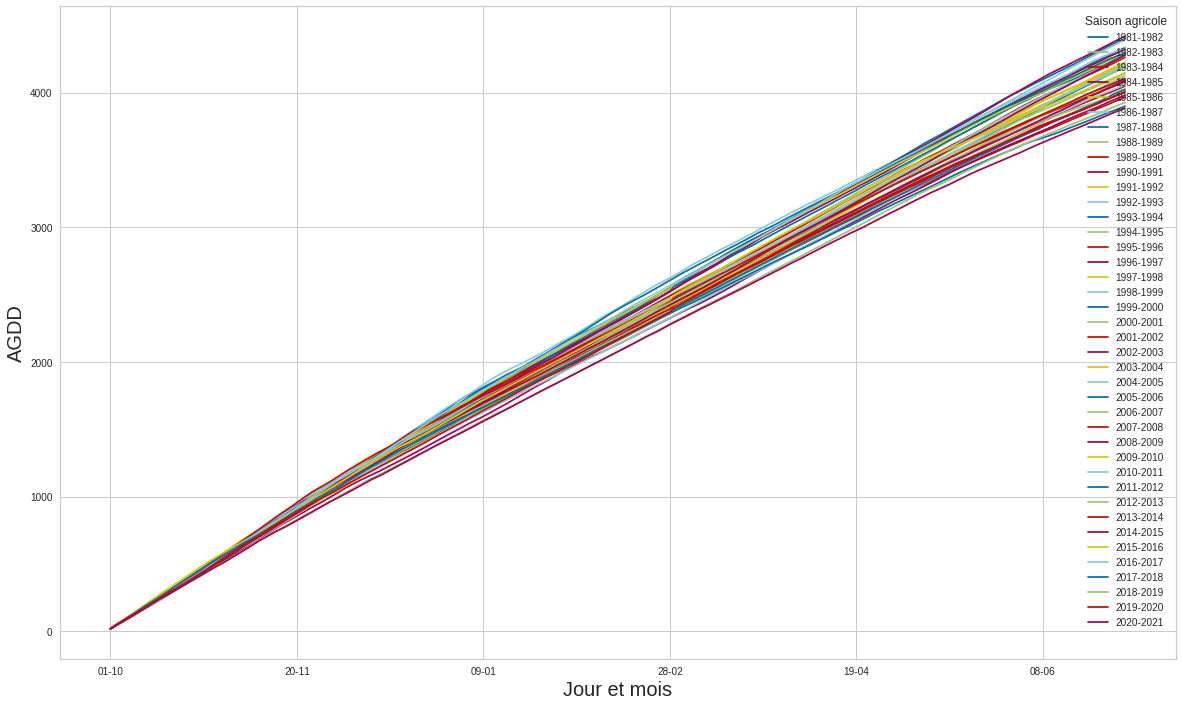

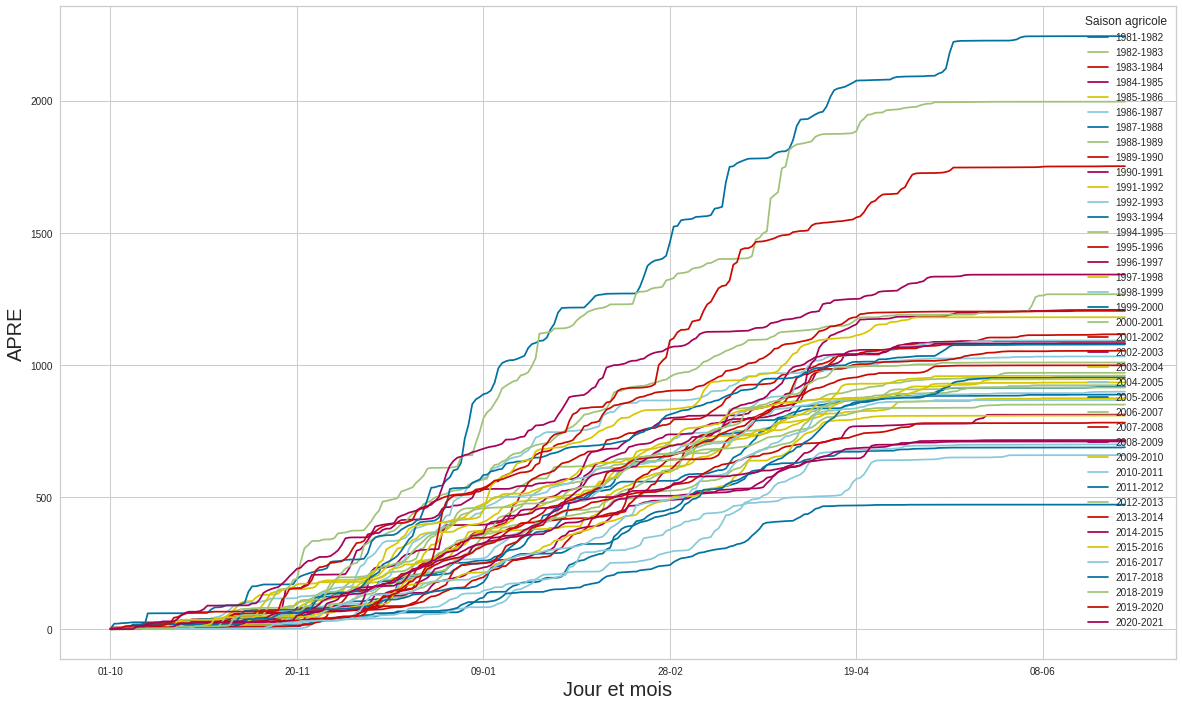

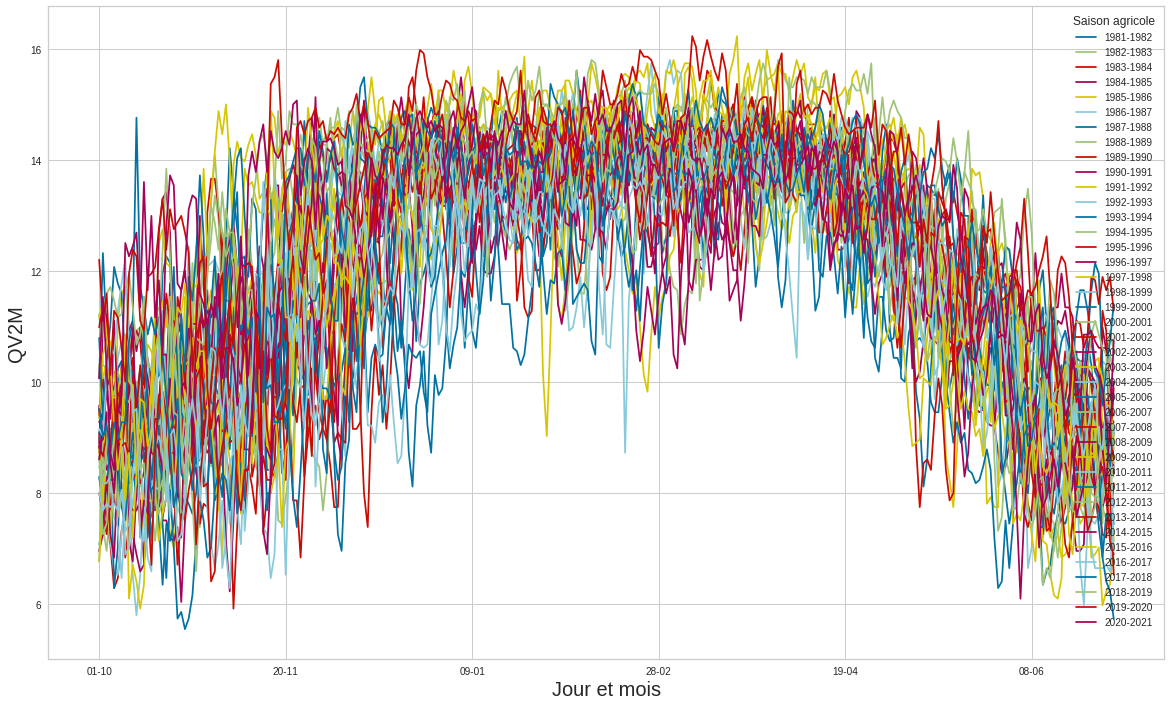

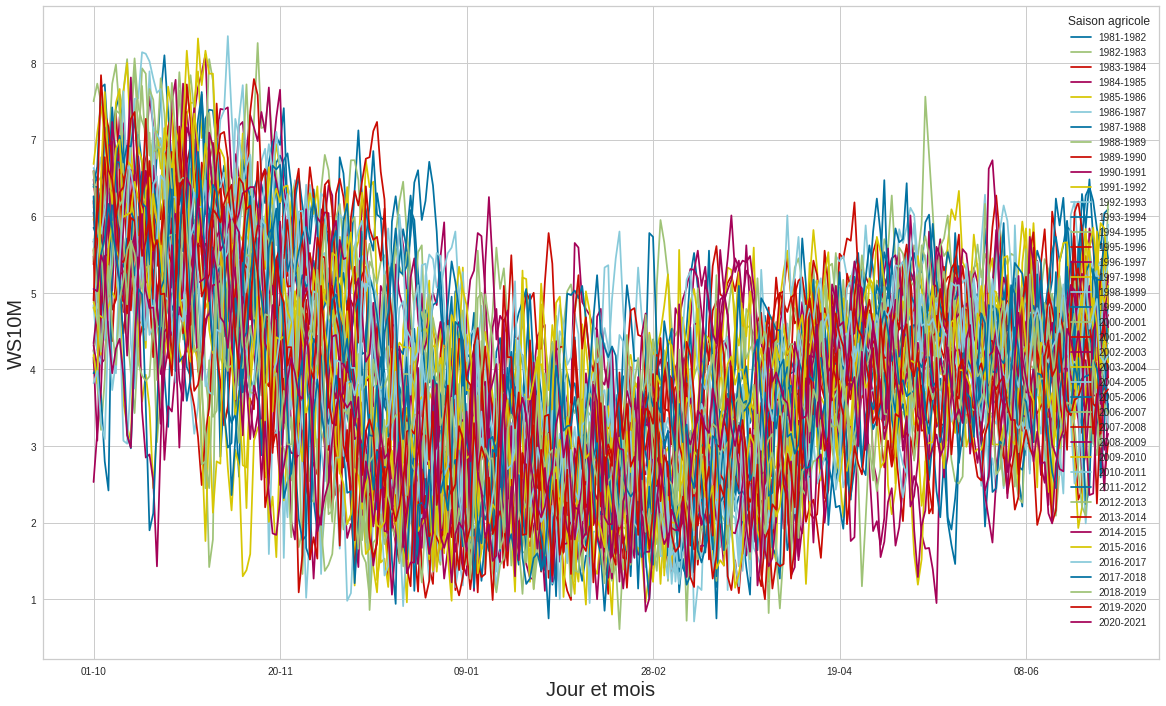

In [135]:
Plotting_seasons(d)

## **min max**

In [136]:
def minmax(data):
    datanorm = (data-min(data.min()))/(max(data.max())-min(data.min()))
    datanorm.head()
    return datanorm

In [137]:
TAGDDscaled=minmax(T)
TAGDDscaled.head()

Jour-Mois,01-10,02-10,03-10,04-10,05-10,...,26-06,27-06,28-06,29-06,30-06
Saison agricole,,,,,,,,,,,
1981-1982,0.000653,0.004242,0.008138,0.012199,0.016427,...,0.936469,0.939349,0.942087,0.944928,0.948083
1982-1983,0.000538,0.004319,0.008120,0.012039,0.016180,...,0.967576,0.970621,0.973614,0.976580,0.979860
1983-1984,0.000775,0.004854,0.008824,0.012858,0.016609,...,0.886402,0.888966,0.891593,0.894207,0.896717
1984-1985,0.000309,0.003873,0.007759,0.011491,0.015421,...,0.889982,0.892578,0.895246,0.897870,0.900323
1985-1986,0.000435,0.004174,0.008045,0.011782,0.015674,...,0.917333,0.919833,0.922314,0.924690,0.927290


In [138]:
TAGDDscaled=minmax(T)
TAGDDscaled.head()

Jour-Mois,01-10,02-10,03-10,04-10,05-10,...,26-06,27-06,28-06,29-06,30-06
Saison agricole,,,,,,,,,,,
1981-1982,0.000653,0.004242,0.008138,0.012199,0.016427,...,0.936469,0.939349,0.942087,0.944928,0.948083
1982-1983,0.000538,0.004319,0.008120,0.012039,0.016180,...,0.967576,0.970621,0.973614,0.976580,0.979860
1983-1984,0.000775,0.004854,0.008824,0.012858,0.016609,...,0.886402,0.888966,0.891593,0.894207,0.896717
1984-1985,0.000309,0.003873,0.007759,0.011491,0.015421,...,0.889982,0.892578,0.895246,0.897870,0.900323
1985-1986,0.000435,0.004174,0.008045,0.011782,0.015674,...,0.917333,0.919833,0.922314,0.924690,0.927290


## **ELbow**

In [139]:
from yellowbrick.cluster import KElbowVisualizer

In [140]:
def Clustering_with_timeseriesKmeans(data_scaled):
    metric_params = {"global_constraint":"sakoe_chiba", "sakoe_chiba_radius": 10}
    vis=kelbow_visualizer(TimeSeriesKMeans(random_state=42), data_scaled, k=(2,10), metric_params=metric_params,locate_elbow=True, timings=False, show=True)
    vis.fit(data_scaled)
    num_K=vis.elbow_value_
    # sakoe_chiba_radius=None, itakura_max_slope=None
    models = tslearn.clustering.TimeSeriesKMeans(n_clusters=num_K, metric='dtw',random_state=42, metric_params=metric_params)
    predictions = models.fit_predict(data_scaled)
    return num_K, predictions

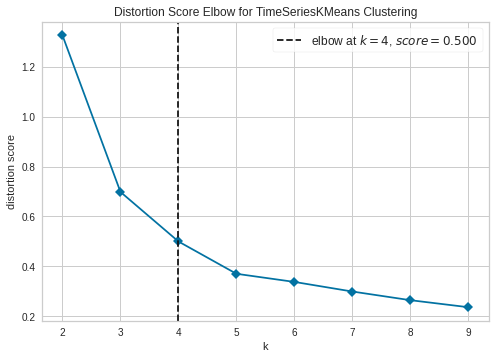

(4, array([2, 1, 0, 0, 3, 0, 1, 3, 3, 1, 2, 3, 1, 2, 3, 0, 2, 1, 1, 3, 2, 1,
        1, 2, 1, 0, 0, 3, 2, 2, 0, 3, 3, 2, 3, 1, 0, 0, 0, 0]))

In [141]:
 M=Clustering_with_timeseriesKmeans(TAGDDscaled)
 M

In [142]:
def Clusteringplots(data_scaled):
    metric_params = {"global_constraint":"sakoe_chiba", "sakoe_chiba_radius": 10}
    vis=kelbow_visualizer(TimeSeriesKMeans(random_state=42), data_scaled, k=(2,10), metric_params=metric_params,locate_elbow=True, timings=False, show=True)
    vis.fit(data_scaled)
    num_K=vis.elbow_value_
    # sakoe_chiba_radius=None, itakura_max_slope=None
    models = tslearn.clustering.TimeSeriesKMeans(n_clusters=num_K, metric='dtw',random_state=42, metric_params=metric_params)
    predictions = models.fit_predict(data_scaled)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(20,10))

    #plt.figure(figsize=(20,10))
    X_train = data_scaled.values
    for yi in range(4):
        plt.subplot(2, 2, yi + 1)
        for xx in X_train[predictions == yi]:
            _index = T.columns.values
            n_indices = _index.shape[0]
            _index = [_index[i] for i in range(n_indices) if i%31==0 ]
            plt.plot(xx.ravel(), "k-", alpha=.2)
            plt.xticks(ticks = [i for i in range(n_indices) if  i%31==0], labels = _index)
        plt.plot(models.cluster_centers_[yi].ravel(), "r-")
        plt.xlim(0, X_train.shape[1])
        # plt.ylim(-10, 10)
        plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
                    transform=plt.gca().transAxes)
    data_scaled["cluster"] = predictions
    #data_scaled.insert(0, "Date", data_scaled.index)
    #data_scaled_melted = pd.melt(data_scaled, id_vars =  ["Date", "cluster"], value_name="AGDD")
    #data_scaled_melted.reset_index(inplace=True, drop = True)
    print(f"the number optimal of classes is:{num_K}")
    print('Cluster 1 :', list(data_scaled[data_scaled.cluster == 0].index))
    print('Cluster 2 :', list(data_scaled[data_scaled.cluster == 1].index))
    print('Cluster 3 :', list(data_scaled[data_scaled.cluster == 2].index))
    print('Cluster 4 :', list(data_scaled[data_scaled.cluster == 3].index))
    return  

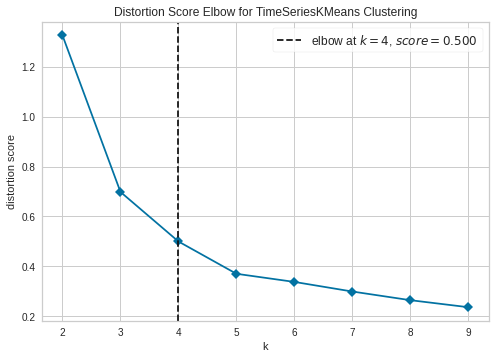

the number optimal of classes is:4
Cluster 1 : ['1983-1984', '1984-1985', '1986-1987', '1996-1997', '2006-2007', '2007-2008', '2011-2012', '2017-2018', '2018-2019', '2019-2020', '2020-2021']
Cluster 2 : ['1982-1983', '1987-1988', '1990-1991', '1993-1994', '1998-1999', '1999-2000', '2002-2003', '2003-2004', '2005-2006', '2016-2017']
Cluster 3 : ['1981-1982', '1991-1992', '1994-1995', '1997-1998', '2001-2002', '2004-2005', '2009-2010', '2010-2011', '2014-2015']
Cluster 4 : ['1985-1986', '1988-1989', '1989-1990', '1992-1993', '1995-1996', '2000-2001', '2008-2009', '2012-2013', '2013-2014', '2015-2016']


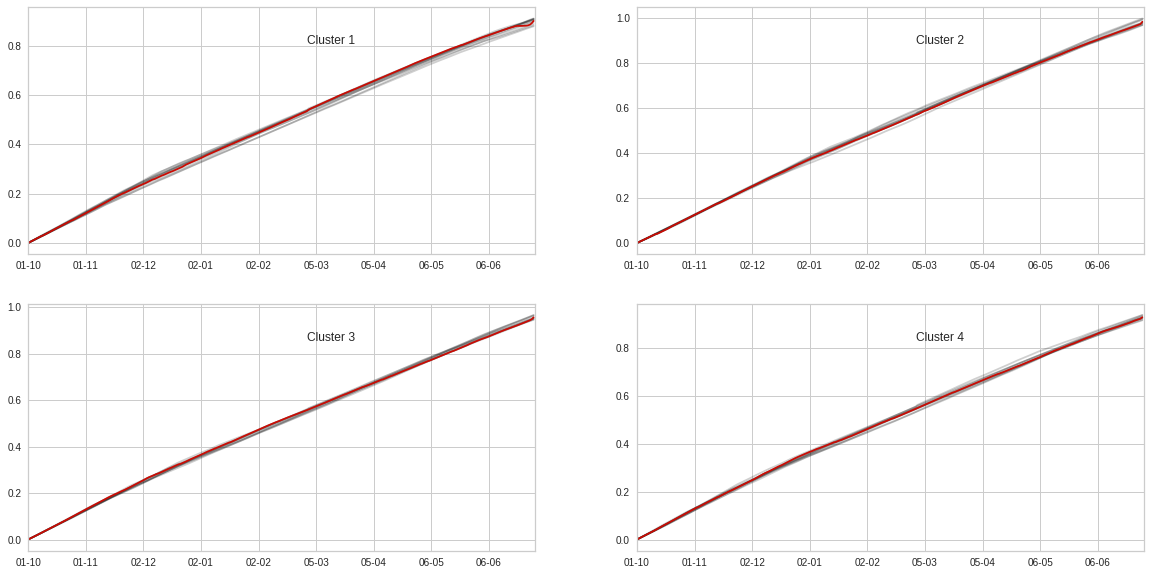

In [143]:
 J=Clusteringplots(TAGDDscaled)
 J

## **Metrics for validation**

In [144]:
from tslearn.metrics import cdist_dtw
def silhouette_score_fct(data_scaled):
    predictions=Clustering_with_timeseriesKmeans(data_scaled)
    metric_params = {"global_constraint":"sakoe_chiba", "sakoe_chiba_radius": 10}
    s=tslearn.clustering.silhouette_score(data_scaled,predictions[1], metric="dtw",random_state=5, metric_params=metric_params) 
    return s


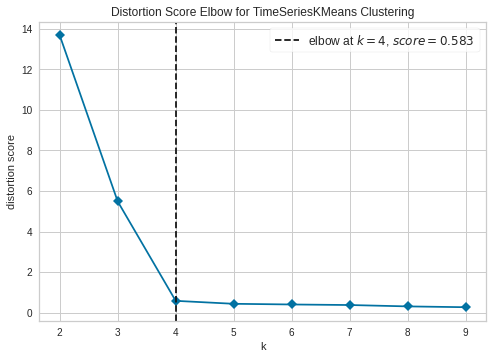

0.975590879689614

In [145]:
silhouette_score_fct(TAGDDscaled)

In [146]:
from tslearn.metrics import cdist_dtw
import  sklearn
results = {}
def calinski_harabasz_score(data_scaled):
    predictions=Clustering_with_timeseriesKmeans(data_scaled)
    metric_params = {"global_constraint":"sakoe_chiba", "sakoe_chiba_radius": 10}
    s=sklearn.metrics.calinski_harabasz_score(data_scaled,predictions[1] )
    return s

 #make a new database osafi

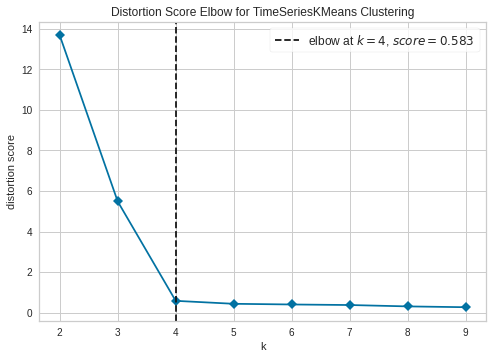

1132.843778701668

In [147]:
calinski_harabasz_score(TAGDDscaled)

## for the means

In [148]:
T

Jour-Mois,01-10,02-10,03-10,04-10,05-10,...,26-06,27-06,28-06,29-06,30-06
Saison agricole,,,,,,,,,,,
1981-1982,17.400,33.215,50.380,68.275,86.900,...,4140.545,4153.235,4165.300,4177.815,4191.715
1982-1983,16.895,33.555,50.300,67.570,85.815,...,4277.600,4291.020,4304.205,4317.275,4331.725
1983-1984,17.940,35.910,53.405,71.175,87.705,...,3919.955,3931.250,3942.825,3954.345,3965.400
1984-1985,15.885,31.590,48.710,65.155,82.470,...,3935.730,3947.165,3958.920,3970.480,3981.290
1985-1986,16.440,32.915,49.970,66.435,83.585,...,4056.235,4067.250,4078.180,4088.650,4100.105
1986-1987,16.570,32.495,48.955,66.140,83.485,...,3966.420,3978.615,3991.200,4003.435,4014.565
1987-1988,17.410,33.745,50.200,66.380,81.985,...,4283.675,4296.075,4308.675,4321.820,4335.805
1988-1989,17.285,34.820,52.675,70.665,87.500,...,4044.785,4057.690,4069.060,4080.760,4093.695
1989-1990,17.170,34.875,52.785,70.755,88.805,...,4002.660,4013.655,4024.610,4036.650,4049.305


In [149]:
def means_AGDD():
    pd.set_option('max_columns', 6)
    predictionsT=Clustering_with_timeseriesKmeans(minmax(pivot_with_AGDD(d)))
    #predictionsP=Clustering_with_timeseriesKmeans(minmax(pivot_with_APRE(d)))

    X=pivot_with_AGDD(d)
    X["cluster"] = predictionsT[1]

    Tcarac = {i: X[X.cluster == i] for i in X.cluster}
    for i in X.cluster :
        Tcarac[i]['Max']=Tcarac[i].iloc[:, 0:366].max(axis=1)  
    agdd_means=[]
    for i in X.cluster:
        agdd_means.append(Tcarac[i][['Max']].mean(axis=0).item())
    
    agdd_means=pd.DataFrame(agdd_means,columns = ['La moyenne de l\'AGDD pour chaque cluster'],index=X.index)
    agdd_means=agdd_means.join(X[["cluster"]])
    
    return agdd_means
    
    

In [150]:
def means_APRE():
    pd.set_option('max_columns', 6)
    predictionsP=Clustering_with_timeseriesKmeans(minmax(pivot_with_APRE(d)))

    Y=pivot_with_APRE(d)
    Y["cluster"] = predictionsP[1]

    Pcarac = {i: Y[Y.cluster == i] for i in Y.cluster}
    for i in Y.cluster :
        Pcarac[i]['Max']=Pcarac[i].iloc[:, 0:366].max(axis=1)  
    apre_means=[]
    for i in Y.cluster:
        apre_means.append(Pcarac[i][['Max']].mean(axis=0).item())
    
    apre_means=pd.DataFrame(apre_means,columns = ['La moyenne de l\'APRE pour chaque cluster'],index=Y.index)
    apre_means=apre_means.join(Y[["cluster"]])
    
    return apre_means

In [151]:
def final_data():
    agdd_means=means_AGDD()
    apre_means=means_APRE()
    Final_data=pd.DataFrame(agdd_means["La moyenne de l'AGDD pour chaque cluster"])
    Final_data["La moyenne de l'APRE pour chaque cluster"]=apre_means["La moyenne de l'APRE pour chaque cluster"]
    return Final_data

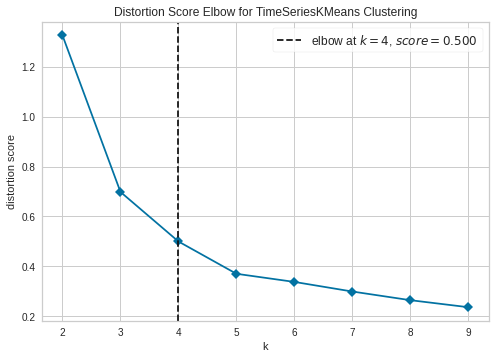

<ipython-input-149-cbb3422b9126>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tcarac[i]['Max']=Tcarac[i].iloc[:, 0:366].max(axis=1)


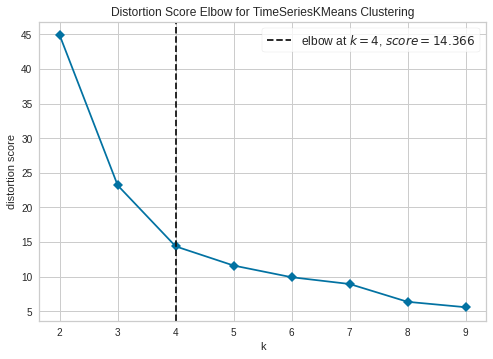

<ipython-input-150-8911d551c688>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Pcarac[i]['Max']=Pcarac[i].iloc[:, 0:366].max(axis=1)


,La moyenne de l'AGDD pour chaque cluster,La moyenne de l'APRE pour chaque cluster
Saison agricole,,
1981-1982,4228.003889,955.523684
1982-1983,4341.400500,955.523684
1983-1984,3976.860000,1175.427778
1984-1985,3976.860000,1175.427778
1985-1986,4099.402500,955.523684
1986-1987,3976.860000,1175.427778
1987-1988,4341.400500,955.523684
1988-1989,4099.402500,955.523684
1989-1990,4099.402500,955.523684


In [152]:
final_data()

## Final clustering

In [153]:
from sklearn.preprocessing import MinMaxScaler
def minmaxscaling_final():
    scaler = MinMaxScaler()
    Final_data=final_data()
    col = Final_data.columns
    dfscaled = scaler.fit_transform(Final_data)
    dfscaled = pd.DataFrame(dfscaled,columns=col, index=Final_data.index)
    return dfscaled

In [154]:
from sklearn.cluster import KMeans

def clustering():
    dfscaled=minmaxscaling_final()
    Final_data=final_data()
    visualizer=kelbow_visualizer(KMeans(random_state=42), dfscaled, k=(2,10),locate_elbow=True, timings=False)
    NC= visualizer.elbow_value_
    models = KMeans(n_clusters=NC,random_state=42)
    predictions = models.fit_predict(Final_data)
    print(predictions)
    Final_data["Final_Clustering"]=models.labels_
    print('Cluster 1 :', list(Final_data[Final_data.Final_Clustering == 0].index))
    print('Cluster 2 :', list(Final_data[Final_data.Final_Clustering == 1].index))
    print('Cluster 3 :', list(Final_data[Final_data.Final_Clustering == 2].index))
    print('Cluster 4 :', list(Final_data[Final_data.Final_Clustering == 3].index))
    print('Cluster 5 :', list(Final_data[Final_data.Final_Clustering == 4].index))
    return
    


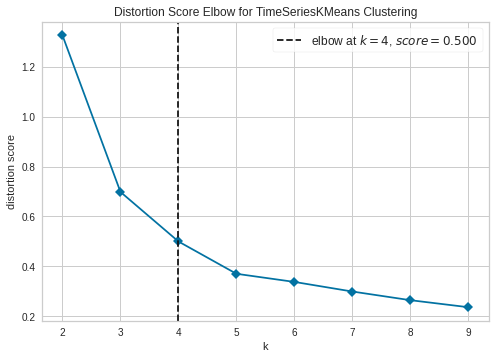

<ipython-input-149-cbb3422b9126>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tcarac[i]['Max']=Tcarac[i].iloc[:, 0:366].max(axis=1)


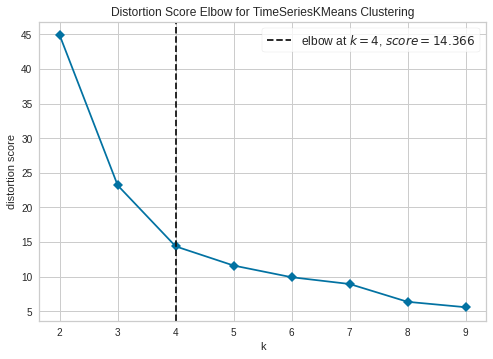

<ipython-input-150-8911d551c688>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Pcarac[i]['Max']=Pcarac[i].iloc[:, 0:366].max(axis=1)


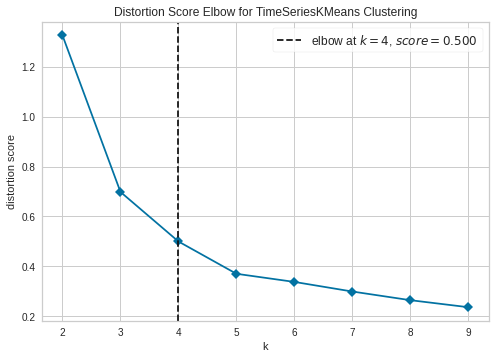

<ipython-input-149-cbb3422b9126>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tcarac[i]['Max']=Tcarac[i].iloc[:, 0:366].max(axis=1)


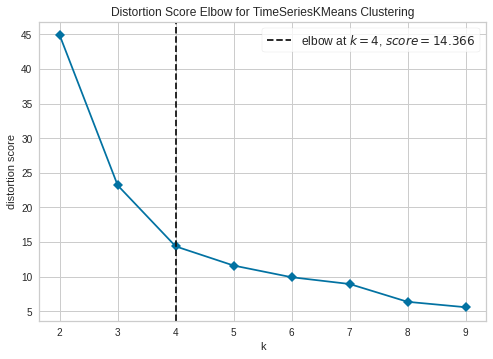

<ipython-input-150-8911d551c688>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Pcarac[i]['Max']=Pcarac[i].iloc[:, 0:366].max(axis=1)


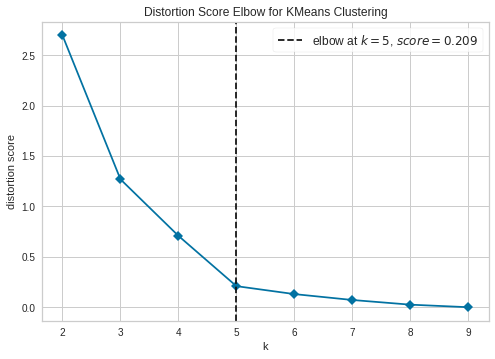

[1 1 2 2 4 2 1 4 4 3 1 4 3 1 4 2 1 3 3 4 3 3 3 1 1 2 4 4 1 1 2 4 2 3 2 3 0
 0 0 2]
Cluster 1 : ['2017-2018', '2018-2019', '2019-2020']
Cluster 2 : ['1981-1982', '1982-1983', '1987-1988', '1991-1992', '1994-1995', '1997-1998', '2004-2005', '2005-2006', '2009-2010', '2010-2011']
Cluster 3 : ['1983-1984', '1984-1985', '1986-1987', '1996-1997', '2006-2007', '2011-2012', '2013-2014', '2015-2016', '2020-2021']
Cluster 4 : ['1990-1991', '1993-1994', '1998-1999', '1999-2000', '2001-2002', '2002-2003', '2003-2004', '2014-2015', '2016-2017']
Cluster 5 : ['1985-1986', '1988-1989', '1989-1990', '1992-1993', '1995-1996', '2000-2001', '2007-2008', '2008-2009', '2012-2013']


In [155]:
clustering()